In [6]:
#%matplotlib inline
import argparse
import os
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


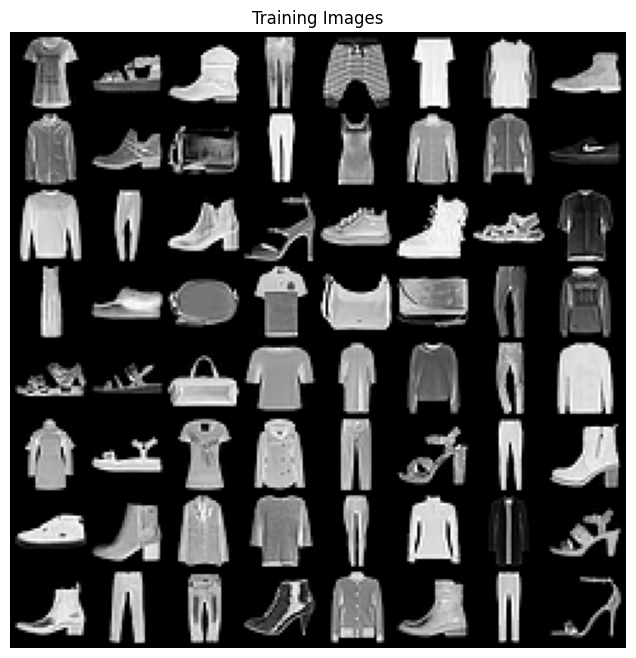

In [12]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming your CSV has label as first column, and image data flattened in remaining columns
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape((28, 28, 1)) 
        label = self.data.iloc[idx, 0] 
        if self.transform:
            image = self.transform(image)
        return image, label

# Defining the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

# Replace "mnist.csv" with your actual csv file path
dataset = MNISTDataset("../data/fashion-mnist_train.csv", transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

# Visualizing the data
real_batch, _ = next(iter(dataloader))  
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))